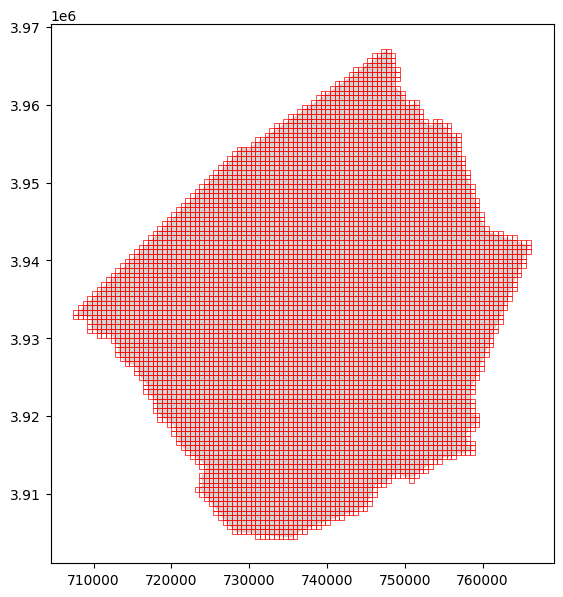

In [1]:
import os
import sys

sys.path.append("../model")
sys.path.append("..")

import math
import geopandas as gpd
import numpy as np
import pystac_client
import planetary_computer
import rioxarray
import xarray as xr
import rasterio
import rasterio.plot
import rasterio.warp
from rasterio.enums import Resampling
from rasterio.merge import merge
from rasterio.windows import from_bounds
# import stackstac
from tqdm import tqdm
from IPython.display import clear_output
import pickle as pkl
from datetime import datetime, date, timedelta
import json
from collections import defaultdict
import glob
from shapely.geometry import box, mapping, Polygon, Point
import heapq
import torch
import yaml
from box import Box
import matplotlib.pyplot as plt
from sklearn import decomposition
from torchvision.transforms import v2
from src.model import ClayMAEModule

# Define your data directory and tile size
tiles_data_dir = "../data/tiles_gdb"
if not os.path.exists(tiles_data_dir):
    os.mkdir(tiles_data_dir)

tiles_geojson_path = "../data/tiles.geojson"
tile_size = 600

# TO BE REMOVED
if os.path.exists(tiles_geojson_path):
    os.remove(tiles_geojson_path)

county_boundary = gpd.read_file("../data/county_boundary.shp")
# Reproject to EPSG:32617 (UTM Zone 17N), which is the CRS used by 
# Sentinel-2 images in this region
if county_boundary.crs != 32617:
    county_boundary = county_boundary.to_crs("EPSG:32617")
    county_boundary.to_file("../data/county_boundary.shp")

minx, miny, maxx, maxy = county_boundary.total_bounds

# Adjust the bounds so that they align with the tile size
# For minx and miny, floor to the nearest multiple of tile_size
minx = math.floor(minx / tile_size) * tile_size
miny = math.floor(miny / tile_size) * tile_size
# For maxx and maxy, ceil to the nearest multiple of tile_size
maxx = math.ceil(maxx / tile_size) * tile_size
maxy = math.ceil(maxy / tile_size) * tile_size

# Generate tiles (i.e., bounding boxes in the format of xmin, ymin, xmax, ymax) 
# to fill the county boundary. If it overlaps the edge, extend outside (rather 
# than coming up short within the boundary), to ensure full coverage
# Get the bounds of the county boundary

if not os.path.exists(tiles_geojson_path):
    # Generate the grid of tiles
    all_tiles = []
    x_coords = np.arange(minx, maxx, tile_size)
    y_coords = np.arange(miny, maxy, tile_size)

    for x in x_coords:
        for y in y_coords:
            # Create a box for each tile
            tile = box(x, y, x + tile_size, y + tile_size)
            all_tiles.append(tile)
    # Create a GeoDataFrame for the tiles
    tiles_gdf = gpd.GeoDataFrame({'geometry': all_tiles}, crs=county_boundary.crs)
    # Keep only tiles that intersect the county, but keep their full geometry
    tiles_gdf = tiles_gdf[tiles_gdf.geometry.intersects(county_boundary.union_all())]\
        .reset_index(drop=True)
    # Remove duplicate tiles
    tiles_gdf = tiles_gdf.drop_duplicates()
    # Add columns for tracking satellite data
    tiles_gdf['processed'] = False
    tiles_gdf['data_files'] = [[] for _ in range(len(tiles_gdf))]
    # Save tiles_gdf to GeoJSON
    tiles_gdf.to_file(tiles_geojson_path, driver='GeoJSON')
else:
    tiles_gdf = gpd.read_file(tiles_geojson_path)

# Generate raster and shapefile masks that match the external 
# bounds (and crs) of all of the tiles since it will not perfectly align with 
# the original boundary


# Create a unified boundary from all the tiles
tiles_union = tiles_gdf.union_all()

# Save the unified tiles boundary as a shapefile mask
tiles_union_gdf = gpd.GeoDataFrame(geometry=[tiles_union], crs=tiles_gdf.crs)
tiles_union_shapefile_path = "../data/tiles_union_mask.shp"
tiles_union_gdf.to_file(tiles_union_shapefile_path)

# Create a raster mask matching the external bounds and CRS of all tiles
# Define the raster properties
minx_tiles, miny_tiles, maxx_tiles, maxy_tiles = tiles_union.bounds
pixel_size = 10  # Pixel size in meters (adjust as needed)

# Calculate the number of rows and columns
ncols = int((maxx_tiles - minx_tiles) / pixel_size)
nrows = int((maxy_tiles - miny_tiles) / pixel_size)

# Define the transform for the raster
transform = rasterio.transform.from_origin(minx_tiles, maxy_tiles, 
                                           pixel_size, pixel_size)

# Define the raster metadata
raster_meta = {
    'driver': 'GTiff',
    'height': nrows,
    'width': ncols,
    'count': 1,
    'dtype': 'uint8',
    'crs': tiles_gdf.crs,
    'transform': transform
}

# Path to save the raster mask
raster_mask_path = "../data/tiles_union_mask.tif"

# Create the raster mask
with rasterio.open(raster_mask_path, 'w', **raster_meta) as out_raster:
    # Burn the unified tiles geometry into the raster
    shapes = [(tiles_union, 1)]
    burned = rasterio.features.rasterize(
        shapes,
        out_shape=(nrows, ncols),
        transform=transform,
        fill=0,
        all_touched=True,
        dtype='uint8'
    )
    out_raster.write_band(1, burned)

# Visualize the tiles and vectors (optional)
ax = county_boundary.plot(color='lightgray', figsize=(7, 7))
tiles_gdf.boundary.plot(ax=ax, edgecolor='red', linewidth=0.5)
plt.show()

In [2]:
print(f"The data region is sub-divided into {len(tiles_gdf)} distinct tiles.")

# Calculate the width and height of each tile
tiles_gdf['width'] = tiles_gdf.geometry.bounds.apply(lambda row: row.maxx - row.minx, axis=1)
tiles_gdf['height'] = tiles_gdf.geometry.bounds.apply(lambda row: row.maxy - row.miny, axis=1)

# Check if all tiles have the same width and height
unique_widths = tiles_gdf['width'].unique()
unique_heights = tiles_gdf['height'].unique()

if len(unique_widths) == 1 and len(unique_heights) == 1:
    print(f"All tiles have uniform size: width = {unique_widths[0]} meters, height = {unique_heights[0]} meters.")
else:
    print("Tiles have varying sizes:")
    print(tiles_gdf[['width', 'height']])


The data region is sub-divided into 5954 distinct tiles.
All tiles have uniform size: width = 600.0 meters, height = 600.0 meters.


In [3]:
# Urban Imperviousness Data - https://www.sciencebase.gov/catalog/item/604a500ed34eb120311b006c

# Path to urban imperviousness data
ui2016_path = "//tsclient/D/data/nlcd_2016_impervious_l48_20210604/nlcd_2016_impervious_l48_20210604.img"

urban_data_dir = "../data/urban_gdb"
if not os.path.exists(urban_data_dir):
    os.mkdir(urban_data_dir)

def urban_file_name(year, data_dir):
    return os.path.join(data_dir, f"nlcd_impervious_{year}.tif")

def extract_urban_by_year_tile_by_tile(ui_path, year, tiles_gdf, urban_data_dir="../data/urban_gdb", 
                                       target_resolution=10):
    """
    Process and extract urban imperviousness data for each tile to avoid memory errors and resample to target resolution.

    Parameters:
    - ui_path (str): Path to the urban imperviousness raster data.
    - year (int): Year of the data (used for naming purposes).
    - tiles_gdf (GeoDataFrame): GeoDataFrame containing the tiles.
    - urban_data_dir (str): Directory to save the urban imperviousness tiles.
    - target_resolution (int): Target resolution for resampling, in meters (default is 10m).

    Returns:
    - tiles_gdf (GeoDataFrame): Updated GeoDataFrame with paths to the urban imperviousness tiles.
    """
    # Ensure the output directory exists
    if not os.path.exists(urban_data_dir):
        os.makedirs(urban_data_dir)

    # Reproject tiles_gdf to match the CRS of the urban imperviousness data
    with rasterio.open(ui_path) as ui_dataset:
        ui_crs = ui_dataset.crs
    tiles_gdf_ui_crs = tiles_gdf.to_crs(ui_crs)

    # Add a new column in tiles_gdf for the urban imperviousness tile path if it doesn't exist
    if 'ui_tile_path' not in tiles_gdf.columns:
        tiles_gdf['ui_tile_path'] = None

    for idx, tile in tiles_gdf_ui_crs.iterrows():
        # Check if the tile has already been processed
        ui_tile_filename = f"ui_tile_{year}_{idx}.tif"
        ui_tile_path = os.path.join(urban_data_dir, ui_tile_filename)
        if os.path.exists(ui_tile_path):
            # Update the tiles_gdf
            tiles_gdf.at[idx, 'ui_tile_path'] = ui_tile_path
            continue
        
        # Get the tile bounds
        minx, miny, maxx, maxy = tile.geometry.bounds

        # Open the dataset within the loop
        with rasterio.open(ui_path) as ui_dataset:
            # Define the window to read
            window = from_bounds(minx, miny, maxx, maxy, transform=ui_dataset.transform)

            # Read the data within the window
            try:
                ui_tile_data = ui_dataset.read(1, window=window)
            except ValueError:
                print(f"No data for tile {idx}")
                continue

            # Check if the tile contains data
            if np.all(ui_tile_data == ui_dataset.nodata):
                print(f"No data in tile {idx}")
                continue

            # Define the transform for the tile
            tile_transform = ui_dataset.window_transform(window)

            # Calculate the resampling scale factors for both dimensions
            scale_x = ui_dataset.res[0] / target_resolution
            scale_y = ui_dataset.res[1] / target_resolution

            # Create a destination array for the resampled data
            dest_shape = (
                int(ui_tile_data.shape[0] * scale_y),
                int(ui_tile_data.shape[1] * scale_x)
            )
            dest_array = np.empty(dest_shape, dtype=ui_tile_data.dtype)

            # Reproject and resample to the target resolution
            rasterio.warp.reproject(
                source=ui_tile_data,
                destination=dest_array,
                src_transform=tile_transform,
                src_crs=ui_dataset.crs,
                dst_transform=rasterio.transform.from_origin(minx, maxy, target_resolution, target_resolution),
                dst_crs=ui_dataset.crs,
                resampling=Resampling.bilinear  # Choose the resampling method
            )

        # Save the resampled tile to a GeoTIFF
        with rasterio.open(
            ui_tile_path,
            'w',
            driver='GTiff',
            height=dest_array.shape[0],
            width=dest_array.shape[1],
            count=1,
            dtype=dest_array.dtype,
            crs=ui_dataset.crs,
            transform=rasterio.transform.from_origin(minx, maxy, target_resolution, target_resolution),
            nodata=ui_dataset.nodata
        ) as dst:
            dst.write(dest_array, 1)

        # Update the tiles_gdf
        tiles_gdf.at[idx, 'ui_tile_path'] = ui_tile_path

    # Reproject tiles_gdf back to its original CRS if necessary
    tiles_gdf = tiles_gdf.to_crs(tiles_gdf.crs)

    # Save the updated tiles_gdf
    tiles_geojson_path = "../data/tiles.geojson"
    tiles_gdf.to_file(tiles_geojson_path, driver='GeoJSON')

    return tiles_gdf


tiles_gdf = extract_urban_by_year_tile_by_tile(
    ui_path=ui2016_path,
    year=2016,
    tiles_gdf=tiles_gdf,
    urban_data_dir=urban_data_dir
)
# Save the updated tiles_gdf to 'tiles.geojson'
tiles_gdf.to_file(tiles_geojson_path, driver='GeoJSON')

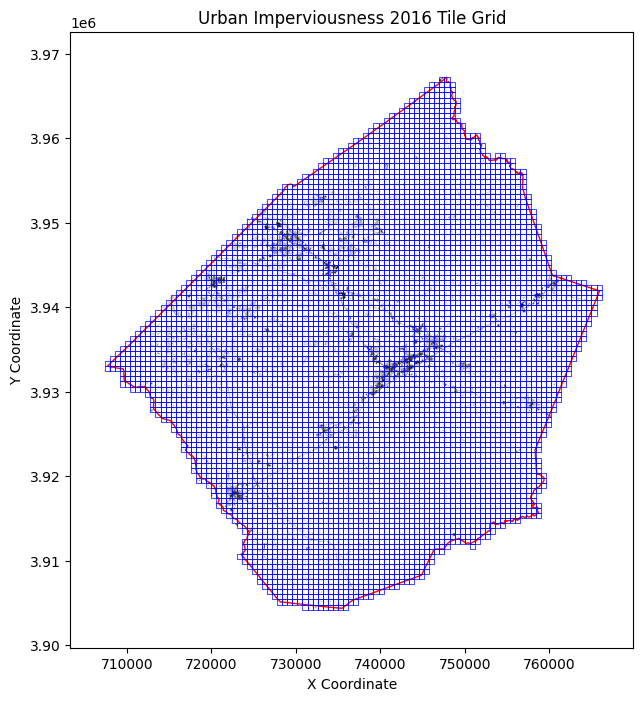

In [4]:
# Paths and variables
mosaic_path = os.path.join("../data", "urban_imperviousness.tif")

# CRS to match (assuming both county_boundary and tiles_gdf have the same CRS)
target_crs = county_boundary.crs

if not os.path.exists(mosaic_path):
    # Get the list of urban imperviousness tile paths
    tile_paths = tiles_gdf['ui_tile_path'].dropna().tolist()

    # List to hold rasterio datasets
    src_files_to_mosaic = []

    # Read each tile and append to the list
    for fp in tile_paths:
        src = rasterio.open(fp)
        src_files_to_mosaic.append(src)

    # Merge the tiles into a mosaic
    mosaic_array, out_trans = merge(src_files_to_mosaic)

    # Close the individual datasets
    for src in src_files_to_mosaic:
        src.close()

    # Get metadata from one of the source files (they should all be the same)
    with rasterio.open(tile_paths[0]) as src0:
        out_meta = src0.meta.copy()

    # Update the metadata to reflect the mosaic dimensions and transform
    out_meta.update({
        "driver": "GTiff",
        "height": mosaic_array.shape[1],
        "width": mosaic_array.shape[2],
        "transform": out_trans,
        "crs": src0.crs  # This is the original CRS of the mosaic
    })

    # Reproject the mosaic array to the target CRS (county_boundary and tiles_gdf CRS)
    dst_array, dst_transform = rasterio.warp.reproject(
        source=mosaic_array,
        src_crs=out_meta['crs'],
        src_transform=out_trans,
        dst_crs=target_crs,  # Target CRS from county_boundary and tiles_gdf
        dst_transform=None,  # Let rasterio calculate the new transform
        resampling=rasterio.enums.Resampling.bilinear  # Choose appropriate resampling method
    )

    # Update metadata to reflect the new dimensions and CRS after reprojection
    out_meta.update({
        "height": dst_array.shape[1],
        "width": dst_array.shape[2],
        "transform": dst_transform,
        "crs": target_crs
    })

    # Save the reprojected mosaic to a file
    with rasterio.open(mosaic_path, "w", **out_meta) as dest:
        dest.write(dst_array)
    
    # Open the saved reprojected mosaic
    mosaic = rasterio.open(mosaic_path)
else:
    # Open the mosaic from file
    mosaic = rasterio.open(mosaic_path)

# Read the data from the mosaic
data = mosaic.read(1)  # Read the first band

# Plot the mosaic
fig, ax = plt.subplots(figsize=(8, 8))

# Use mosaic.transform for the transform parameter
rasterio.plot.show(data, transform=mosaic.transform, ax=ax, cmap='gray_r')

# Plot the county boundary and tile boundaries
county_boundary.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=1)
tiles_gdf.boundary.plot(ax=ax, edgecolor='blue', linewidth=0.5)

plt.title('Urban Imperviousness 2016 Tile Grid')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()


In [5]:

def remove_small_files(directory, min_size_kb):
    """
    Remove all files from the directory that are smaller than min_size_kb kilobytes.

    Parameters:
    directory (str): The path to the directory.
    min_size_kb (int or float): The minimum size of the file in kilobytes. Files smaller than this will be removed.
    """
    # Convert kilobytes to bytes
    min_size_bytes = min_size_kb * 1024
    
    # Iterate over all files in the directory
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        
        # Check if it's a file
        if os.path.isfile(file_path):
            # Get the file size in bytes
            file_size = os.path.getsize(file_path)
            
            # Remove the file if it's smaller than the threshold
            if file_size < min_size_bytes:
                os.remove(file_path)
                print(f"Removed: {filename}, Size: {file_size / 1024:.2f} KB")

def remove_newest_files(directory, n):
    """
    Remove up to n of the newest files from the specified directory.

    Parameters:
    directory (str): The path to the directory.
    n (int): The number of newest files to remove.
    """
    # Get a list of all files in the directory with their modification times
    files_with_times = [
        (os.path.join(directory, filename), os.path.getmtime(os.path.join(directory, filename)))
        for filename in os.listdir(directory)
        if os.path.isfile(os.path.join(directory, filename))
    ]
    
    # Sort the files by their modification time (newest first)
    newest_files = heapq.nlargest(n, files_with_times, key=lambda x: x[1])

    # Remove up to n of the newest files
    for file_path, mod_time in newest_files:
        os.remove(file_path)
        print(f"Removed: {os.path.basename(file_path)}, Modified on: {datetime.fromtimestamp(mod_time)}")

# Clean up files where they did not download all the way, or where the connection may have been interrupted.
remove_small_files(tiles_data_dir, 1)
# remove_newest_files(tiles_data_dir, 5)

In [6]:
def query_available_dates(tile_geometry, catalog, start, end, query, collections=["sentinel-2-l2a"], limit=1000):
    # Get the bounds of the tile in WGS84
    tile_wgs84 = gpd.GeoSeries([tile_geometry], crs="EPSG:32617").to_crs("EPSG:4326").iloc[0]
    minx, miny, maxx, maxy = tile_wgs84.bounds
    bbox = [minx, miny, maxx, maxy]

    # Perform the search
    search = catalog.search(
        collections=collections,
        bbox=bbox,
        datetime=f"{start}/{end}",
        limit=limit,
        query=query
    )

    # Get the items from the search results and collect dates
    items = list(search.items())
    available_dates = [item.datetime.date() for item in items]
    return available_dates


def select_dates_best_spread(dates_list, num_per_year=4):
    # Sort the dates list
    dates_list.sort()
    
    # Determine target months based on the desired number per year
    target_months = {
        4: [3, 6, 9, 12],  # Default quarters: March, June, September, December
        3: [4, 8, 12],     # For 3 dates per year: April, August, December
        2: [6, 12],        # For 2 dates per year: June, December
        1: [6]             # For 1 date per year: June
    }.get(num_per_year, [6])  # Default to June if an unexpected `num_per_year` is given
    
    # Group dates by year
    dates_by_year = defaultdict(list)
    for d in dates_list:
        dates_by_year[d.year].append(d)
    
    selected_dates = []
    
    # Iterate over each year and select the best spread dates
    for year in sorted(dates_by_year.keys()):
        available_dates = dates_by_year[year]
        
        for month in target_months:
            # Set the target date as the 1st of the target month
            target_date_in_year = date(year, month, 1)
            
            # Find the closest date in the available dates to the target date
            closest_date = min(available_dates, key=lambda d: abs(d - target_date_in_year))
            
            # Check if the selected date is not already in the list
            if closest_date not in selected_dates:
                selected_dates.append(closest_date)
    
    # Post-process to ensure cross-year spread is handled
    selected_dates.sort()
    return selected_dates

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1/",
    modifier=planetary_computer.sign_inplace,
)
query = {"eo:cloud_cover": {"lt": 1}}

collections=["sentinel-2-l2a"]

# Dates to query
start = "2016-01-01"
end = "2024-08-31"

if not os.path.exists("../data/available_dates.pkl"):
    available_dates = query_available_dates(tiles_gdf.iloc[0].geometry, catalog, start, end, query)
    with open("../data/available_dates.pkl", "wb") as f:
        pkl.dump(available_dates, f)
else:
    with open("../data/available_dates.pkl", "rb") as f:
        available_dates = pkl.load(f)

print("Number of available dates for processing:", len(available_dates))

selected_dates = select_dates_best_spread([d for d in available_dates if d !=  date(2017, 5, 16) 
                                           and d != date(2024, 8, 27)], 3) # 5/16 is basically unavailable, and 8/25 is already there

print("Number of selected dates for processing:", len(selected_dates))

Number of available dates for processing: 321
Number of selected dates for processing: 25


In [ ]:
# Bands to query:
#  B02 (Blue) - 490 nm (10 m resolution)
#      Useful for water body delineation and identifying vegetation.
#  B03 (Green) - 560 nm (10 m resolution)
#      Useful for vegetation monitoring.
#  B04 (Red) - 665 nm (10 m resolution)
#      Useful for vegetation and crop health monitoring (e.g., chlorophyll absorption).
#  B08 (Near Infrared - NIR) - 842 nm (10 m resolution)
#      Key band for calculating NDVI and monitoring vegetation health.
bands = ["B02", "B03", "B04", "B08"]
bands_map = {"B02": "blue", "B03": "green", "B04": "red", "B08": "nir"}

# GSD (in meters)
gsd = 10

epsg = 32617

# Function to query STAC items for a tile
def query_stac_tile(tile_geometry, catalog, start, end, 
                    query, collections=["sentinel-2-l2a"], 
                    limit=1000):
    # Get the bounds of the tile in WGS84
    tile_wgs84 = gpd.GeoSeries([tile_geometry], crs="EPSG:32617").to_crs("EPSG:4326").iloc[0]
    minx, miny, maxx, maxy = tile_wgs84.bounds
    bbox = [minx, miny, maxx, maxy]

    # Perform the search
    search = catalog.search(
        collections=collections,
        bbox=bbox,
        datetime=f"{start}/{end}",
        limit=limit,
        query=query
    )
    # Get the items from the search results
    items = list(search.item_collection())
    return items

def get_subregion(dataset, bounds):
    min_x, min_y, max_x, max_y = bounds
    # Subset the dataset using xarray's sel function
    subregion = dataset.sel(
        x=slice(min_x, max_x),  # X-coordinate bounds
        y=slice(max_y, min_y)   # Y-coordinate bounds (flip due to coordinate system)
    )
    return subregion

# Function to get images from item
def get_images_from_item(item, bands, output_file_path, 
                         chunk_size=2048, dtype=np.float32, 
                         crs="EPSG:32617", bounds=None):
    # Check if the file already exists
    if not os.path.exists(output_file_path):

        band_datasets = []
        # Loop through bands and collect data
        for band in bands:
            # Sign the asset URLs
            asset_href = planetary_computer.sign(item.assets[band].href)
            # Open the image using rioxarray
            with rasterio.Env():
                ds = rioxarray.open_rasterio(
                    asset_href,
                    chunks={"band": -1, "x": chunk_size, "y": chunk_size},
                    lock=False
                ).astype(dtype)
                if ds.rio.crs != crs:
                    ds = ds.rio.reproject(
                        crs, 
                        resampling=Resampling.nearest,
                        num_threads=2
                    )
                if bounds is not None:
                    ds = get_subregion(ds, bounds)
                band_datasets.append(ds)

        # Stack bands into a single dataset
        stacked_ds = xr.concat(band_datasets, dim='band')

        # Store time as an attribute
        naive_datetime = item.datetime.replace(tzinfo=None)
        time_value = np.datetime64(naive_datetime, 'ns')
        stacked_ds.attrs['time'] = str(time_value)
        
        # Save the stacked dataset to a single GeoTIFF file
        # stacked_ds.rio.to_raster(output_file_path)
        # Write the data using Dask and rioxarray, with windowed=True and tiled=True
        with rasterio.Env(GDAL_CACHEMAX=512):  # Set cache size to 512 MB
            stacked_ds.rio.to_raster(
                output_file_path,
                tiled=True,
                windowed=True,
                blockxsize=256,
                blockysize=256,
                compress="deflate",
                num_threads=2,
                bigtiff='yes'
            )
    return output_file_path

# Function to clean up bounds for filename
def clean_bounds(bounds):
    minx, miny, maxx, maxy = bounds
    # Round to 3 decimal places and remove any special characters
    minx_str = f"{minx:.3f}".replace('.', '_')
    miny_str = f"{miny:.3f}".replace('.', '_')
    maxx_str = f"{maxx:.3f}".replace('.', '_')
    maxy_str = f"{maxy:.3f}".replace('.', '_')
    # Combine into a single string
    bounds_str = f"{minx_str}_{miny_str}_{maxx_str}_{maxy_str}"
    return bounds_str

# Parameters
initial_buffer_days = 0
max_buffer_days = 60  # Maximum buffer to apply
tile_error = []
failed_downloads = []
not_found_items = []

for idx, tile in tiles_gdf[~tiles_gdf['processed']].iterrows():
    try:
        # Clear previous output to keep the notebook clean
        clear_output(wait=True)
        print(f"Processing tile {idx + 1}/{len(tiles_gdf)}")
        
        tile_geometry = tile['geometry']
        
        # Initialize list to store data file paths for the current tile
        tile_data_files = tiles_gdf.at[idx, 'data_files'] if 'data_files' in tiles_gdf.columns else []

        # Create a single progress bar for the entire tile processing
        with tqdm(total=len(selected_dates), desc=f"Tile {idx}: Processing dates", unit=" date", leave=False) as pbar:
            for query_date in selected_dates:
                buffer_days = initial_buffer_days
                found_item = False  # Flag to indicate if an item was found
                
                while not found_item and buffer_days <= max_buffer_days:
                    start = query_date - timedelta(days=buffer_days)
                    end = query_date + timedelta(days=buffer_days)
                    
                    # Define the output file path before querying
                    tile_bounds = tile_geometry.bounds
                    bounds_str = clean_bounds(tile_bounds)
                    band_sfx = "_".join(bands)
                    output_file = os.path.join(tiles_data_dir, f"tile_{idx}_{bounds_str}_{query_date.isoformat()}_{band_sfx}.tif")

                    # Check if the file already exists
                    if os.path.exists(output_file):
                        tile_data_files.append(output_file)
                        status_message = f"\nData file {output_file} already exists, skipping download"
                        pbar.set_postfix_str(status_message, refresh=False)
                        pbar.update(1)
                        found_item = True  # Skip to the next date since the file exists
                        break
                    
                    # Query STAC items for the tile on this specific date with buffer
                    tile_items = query_stac_tile(tile_geometry, catalog, start.isoformat(), end.isoformat(), query, collections=collections)
                    
                    if tile_items:
                        # Collect unique items per date
                        unique_items = {item.datetime.date().isoformat(): item for item in tile_items}
                        
                        for date_str, item in unique_items.items():
                            # Update the output file path for the specific date found
                            output_file = os.path.join(tiles_data_dir, f"tile_{idx}_{bounds_str}_{date_str}_{band_sfx}.tif")
                            
                            if not os.path.exists(output_file):
                                try:
                                    # Download and save the data
                                    get_images_from_item(item, bands, output_file, chunk_size=2048, bounds=tile_bounds)
                                    tile_data_files.append(output_file)
                                    status_message = f"\nSaved data to {output_file}"
                                except Exception as e:
                                    status_message = f"\nError processing item {item.id}: {e}"
                                    failed_downloads.append({
                                        "idx": idx,
                                        "query_date": query_date,
                                        "tile_geometry": tile_geometry,
                                        "tile_bounds": tile_bounds,
                                        "bounds_str": bounds_str,
                                        "band_sfx": band_sfx,
                                        "output_file": output_file,
                                        "item":item, 
                                        "bands":bands
                                    })
                                    continue  # Skip this item and move on to the next
                            else:
                                tile_data_files.append(output_file)
                                status_message = f"\nData file {output_file} already exists, skipping download"
                            
                            # Set the status message without duplicating the progress bar output
                            pbar.set_postfix_str(status_message, refresh=False)
                            pbar.update(1)
                        
                        found_item = True  # Mark as found to exit the while loop
                    else:
                        # Increment the buffer and try again
                        buffer_days += 2
                        tqdm.write(f"\nNo items found for tile {idx} on date {query_date} with buffer of {buffer_days} days")

                if not found_item:
                    # No items found even with the maximum buffer
                    tqdm.write(f"\nNo items found for tile {idx} on date {query_date} within the maximum buffer of {max_buffer_days} days")
                    not_found_items.append({
                        "idx":idx,
                        "query_date": query_date,
                        "tile_geometry": tile_geometry,
                        "tile_bounds": tile_bounds,
                        "bounds_str": bounds_str,
                        "band_sfx": band_sfx,
                        "output_file": output_file
                    })
                    # Update the progress bar even if no items found
                    pbar.update(1)
        
        # Update the GeoDataFrame with the accumulated data files
        tiles_gdf.at[idx, 'data_files'] = tile_data_files
        tiles_gdf.at[idx, 'processed'] = True

    except Exception as e:
        tile_error.append(tile)
        # Use tqdm.write to integrate with progress bar output
        tqdm.write(f"\nError processing tile {idx}: {e}")
        continue  # Skip this tile and move on to the next one

    # Save the updated tiles_gdf to 'tiles.geojson' after each tile
    tiles_gdf.to_file(tiles_geojson_path, driver='GeoJSON')
    
with open('../data/tile_error.pkl', 'wb') as f:
    pkl.dump(tile_error, f)

with open('../data/failed_downloads.pkl', 'wb') as f:
    pkl.dump(failed_downloads, f)
 
with open('../data/not_found_items.pkl', 'wb') as f:
    pkl.dump(not_found_items, f)

In [8]:
# Sometimes it quits out, make sure the gdf updated properly

for idx, tile in tiles_gdf.iterrows():
    tile_geometry = tile['geometry']
    tile_bounds = tile_geometry.bounds
    bounds_str = clean_bounds(tile_bounds)

    # Initialize or retrieve the list to store data file paths for the current tile
    tile_data_files = tiles_gdf.at[idx, 'data_files'] if 'data_files' in tiles_gdf.columns else []

    for query_date in selected_dates:
        output_file = os.path.join(
            tiles_data_dir,
            f"tile_{idx}_{bounds_str}_{query_date.isoformat()}_{band_sfx}.tif"
        )

        if os.path.exists(output_file):
            tile_data_files.append(output_file)
        else:
            # File does not exist; no action needed other than marking as processed
            pass

    # Update the GeoDataFrame
    tiles_gdf.at[idx, 'data_files'] = tile_data_files
    tiles_gdf.at[idx, 'processed'] = True

# Save the updated GeoDataFrame to the GeoJSON file
tiles_gdf.to_file(tiles_geojson_path, driver='GeoJSON')

In [ ]:
from rioxarray.exceptions import NoDataInBounds

def requery_failed_downloads(failed_downloads, catalog, query, 
                          collections=["sentinel-2-l2a"], limit=1000, 
                          save_dir="../data/tiles_gdb", buffer_days=60):

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    no_data_in_bounds = []
    for failed_download in failed_downloads:
        idx = failed_download['idx'] 
        tile_polygon = failed_download['tile_geometry']  
        query_date = failed_download['query_date']
        buffer_days = 0  # Start without buffer
        print(f"Re-querying tile for date: {query_date} at coordinates: {failed_download['tile_bounds']}")
        
        while buffer_days <= buffer_days: 
            start_date = query_date - timedelta(days=buffer_days)
            end_date = query_date + timedelta(days=buffer_days)
            
            # Query the STAC catalog for the missing tile
            items = query_stac_tile(tile_polygon, catalog, start_date.isoformat(), end_date.isoformat(), 
                                    query, collections=collections, limit=limit)
            
            if items:
                for item in items:
                    saved = False
                    # Define the output file path before querying
                    tile_bounds = tile_polygon.bounds
                    bounds_str = clean_bounds(tile_bounds)
                    band_sfx = "_".join(bands)
                    output_file = os.path.join(tiles_data_dir, f"tile_{idx}_{bounds_str}_{query_date.isoformat()}_{band_sfx}.tif")
                    try:
                        if not os.path.exists(output_file):
                            # Save the queried image
                            get_images_from_item(item, bands, output_file, bounds=tile_polygon.bounds)
                            print(f"Saved re-queried tile to {output_file}")
                        saved = True
                    except NoDataInBounds as e:
                        print(e)
                if not saved:
                    no_data_in_bounds.append({
                            'idx': idx,
                            'tile_polygon': tile_polygon,
                            'query_date': query_date 
                        })
                    print(f"Appended {tile_polygon.bounds} {query_date} to `no_data_in_bounds`.")
                
                break  # Stop if data is found and saved
            
            buffer_days += 2  # Increase the buffer by 2 days if no data found

        if buffer_days > buffer_days:
            print(f"Failed to retrieve data for tile {failed_download['tile_bounds']} on date {query_date} within buffer range.")
    return no_data_in_bounds

if len(failed_downloads) > 0:          
    no_data_in_bounds = requery_failed_downloads(failed_downloads, catalog, query=query, save_dir="../data/tiles_gdb")

In [23]:

def parse_date_from_filename(filename):
    """
    Parse the date from the file name.
    The date is assumed to be in ISO format (YYYY-MM-DD) within the file name.
    The date is typically the part just before the band names, which we assume is the third-to-last part.
    """
    try:
        # Normalize the file path to handle potential backward slashes and extract the filename
        base_name = os.path.basename(filename)
        # Split by underscore and extract the date part (which is third-to-last based on the example)
        parts = base_name.split('_')
        # The date part is the one right before the bands (3rd from last)
        date_str = parts[-5]
        # Convert the date string to a date object
        return datetime.strptime(date_str, '%Y-%m-%d').date()
    except (ValueError, IndexError) as e:
        # In case of any error in parsing, return None and print error for debugging
        print(f"Error parsing date from filename '{filename}': {e}")
        return None


def assign_files_to_dates(tiles_gdf, max_buffer_days, selected_dates, tiles_data_dir='../data/tiles_gdb'):

    # Initialize a new column in tiles_gdf to hold the date-to-files mapping
    if 'date_files_mapping' not in tiles_gdf.columns:
        tiles_gdf['date_files_mapping'] = [{} for _ in range(len(tiles_gdf))]

    # Convert selected_dates to strings for GeoJSON compatibility
    selected_dates_str = [d.strftime('%Y-%m-%d') for d in selected_dates]

    for idx, tile in tiles_gdf.iterrows():
        # Get the list of files associated with the current tile
        tile_bounds = tile['geometry'].bounds
        bounds_str = clean_bounds(tile_bounds)
        band_sfx = "_".join(bands)
        data_files = [os.path.join(tiles_data_dir, f"tile_{idx}_{bounds_str}_{query_date.isoformat()}_{band_sfx}.tif") \
                      for query_date in selected_dates]
        
        # Initialize a dictionary with each selected date (as string) as a key and an empty list as the value
        date_files = {selected_date: [] for selected_date in selected_dates_str}
        
        for file in data_files:
            # Extract the date from the file name
            file_date = parse_date_from_filename(file)
            if not file_date:
                continue  # Skip files without valid dates

            # Convert file_date to string for comparison
            file_date_str = file_date.strftime('%Y-%m-%d')
            
            # Check if the file date is within the buffer for any of the selected dates
            for target_date in selected_dates:
                if abs((file_date - target_date).days) <= max_buffer_days:
                    # Add the file to the list of files for the matching target date
                    date_files[target_date.strftime('%Y-%m-%d')].append(file)
        
        # Update the 'date_files_mapping' column with the date-to-files dictionary
        tiles_gdf.at[idx, 'date_files_mapping'] = date_files
    
    # Drop the old 'data_files' column since it's now replaced by 'date_files_mapping'
    if 'data_files' in tiles_gdf.columns:
        tiles_gdf = tiles_gdf.drop(columns=['data_files'])
    
    return tiles_gdf

# Call the function to update the GeoDataFrame
updated_tiles_gdf = assign_files_to_dates(tiles_gdf, max_buffer_days=45, selected_dates=selected_dates, tiles_data_dir='../data/tiles_gdb')

# Save the updated GeoDataFrame to GeoJSON
updated_tiles_geojson_path = "../data/tiles_with_dates.geojson"
updated_tiles_gdf.to_file(updated_tiles_geojson_path, driver='GeoJSON')

print(f"Updated tiles GeoDataFrame saved to {updated_tiles_geojson_path}")

Updated tiles GeoDataFrame saved to ../data/tiles_with_dates.geojson


In [24]:

with open(updated_tiles_geojson_path, 'r') as file:
    geojson_data = json.load(file)

# Initialize containers for results
empty_date_records = []
multiple_file_records = []
non_empty_counts = defaultdict(int)

# Iterate over the features
for feature in geojson_data['features']:
    date_files_mapping = feature['properties']['date_files_mapping']
    
    # Check for empty lists and lists with more than one file
    for date, file_list in date_files_mapping.items():
        if len(file_list) == 0:
            empty_date_records.append((feature['geometry']['coordinates'], date))
        if len(file_list) > 1:
            multiple_file_records.append((feature['geometry']['coordinates'], date, file_list))
        
        # Count non-empty lists per date
        if len(file_list) > 0:
            non_empty_counts[date] += 1
            
# Records with empty file lists
if empty_date_records:
    print("Records with empty file lists:")
    for record in empty_date_records:
        print(f"Coordinates: {record[0]}, Date: {record[1]}")
else:
    print("No records with empty file lists found.")

# Records with more than one file in their list
if multiple_file_records:
    print("\nRecords with more than one file:")
    for record in multiple_file_records:
        print(f"Coordinates: {record[0]}, Date: {record[1]}, Files: {record[2]}")
else:
    print("No records with more than one file found.")

# Non-empty list counts per date
print("\nNon-empty file list counts per date:")
for date, count in non_empty_counts.items():
    print(f"Date: {date}, Count of non-empty lists: {count}")


No records with empty file lists found.
No records with more than one file found.

Non-empty file list counts per date:
Date: 2016-04-14, Count of non-empty lists: 5954
Date: 2016-06-10, Count of non-empty lists: 5954
Date: 2016-11-27, Count of non-empty lists: 5954
Date: 2017-08-19, Count of non-empty lists: 5954
Date: 2017-11-30, Count of non-empty lists: 5954
Date: 2018-03-15, Count of non-empty lists: 5954
Date: 2018-08-07, Count of non-empty lists: 5954
Date: 2018-11-27, Count of non-empty lists: 5954
Date: 2019-04-04, Count of non-empty lists: 5954
Date: 2019-07-30, Count of non-empty lists: 5954
Date: 2019-12-05, Count of non-empty lists: 5954
Date: 2020-04-03, Count of non-empty lists: 5954
Date: 2020-07-19, Count of non-empty lists: 5954
Date: 2020-12-01, Count of non-empty lists: 5954
Date: 2021-04-03, Count of non-empty lists: 5954
Date: 2021-08-08, Count of non-empty lists: 5954
Date: 2021-11-26, Count of non-empty lists: 5954
Date: 2022-04-03, Count of non-empty lists: 595

C:\Users\btripp\AppData\Local\Temp\2\ipykernel_12304\540960019.py:15: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  missing_tiles_gdf.plot(ax=ax, color='black')


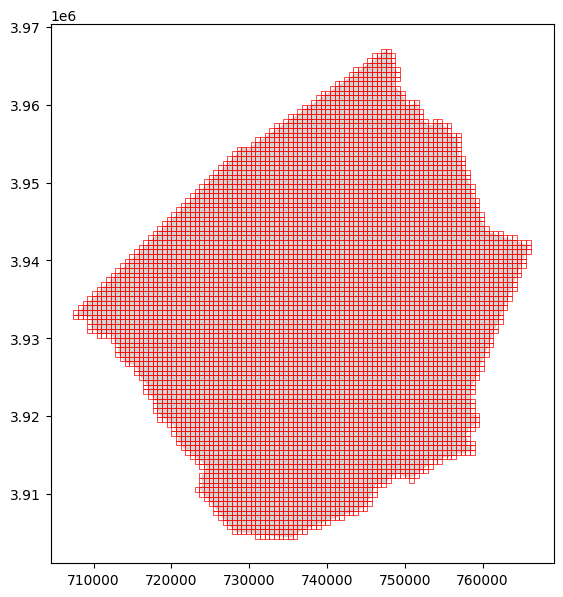

In [25]:
# Extract unique tile coordinates and flatten them to ensure they are tuples of floats
missing_tiles_coords = [tuple([tuple(coord) for coord in record[0]]) for record in empty_date_records]
missing_tiles_coords = [i[0] for i in missing_tiles_coords]

# Convert coordinates to polygons for plotting
missing_tiles_gdf = gpd.GeoDataFrame(
    geometry=[Polygon(coords) for coords in missing_tiles_coords],  # Ensure valid polygons
    crs=updated_tiles_gdf.crs
).drop_duplicates()

# Visualize the tiles, filling in each tile with ANY missing dates (using the unique coordinates from empty_date_records)
ax = county_boundary.plot(color='lightgray', figsize=(7, 7))
updated_tiles_gdf.boundary.plot(ax=ax, edgecolor='red', linewidth=0.5)
# Fill empty tiles with black
missing_tiles_gdf.plot(ax=ax, color='black')
plt.show()

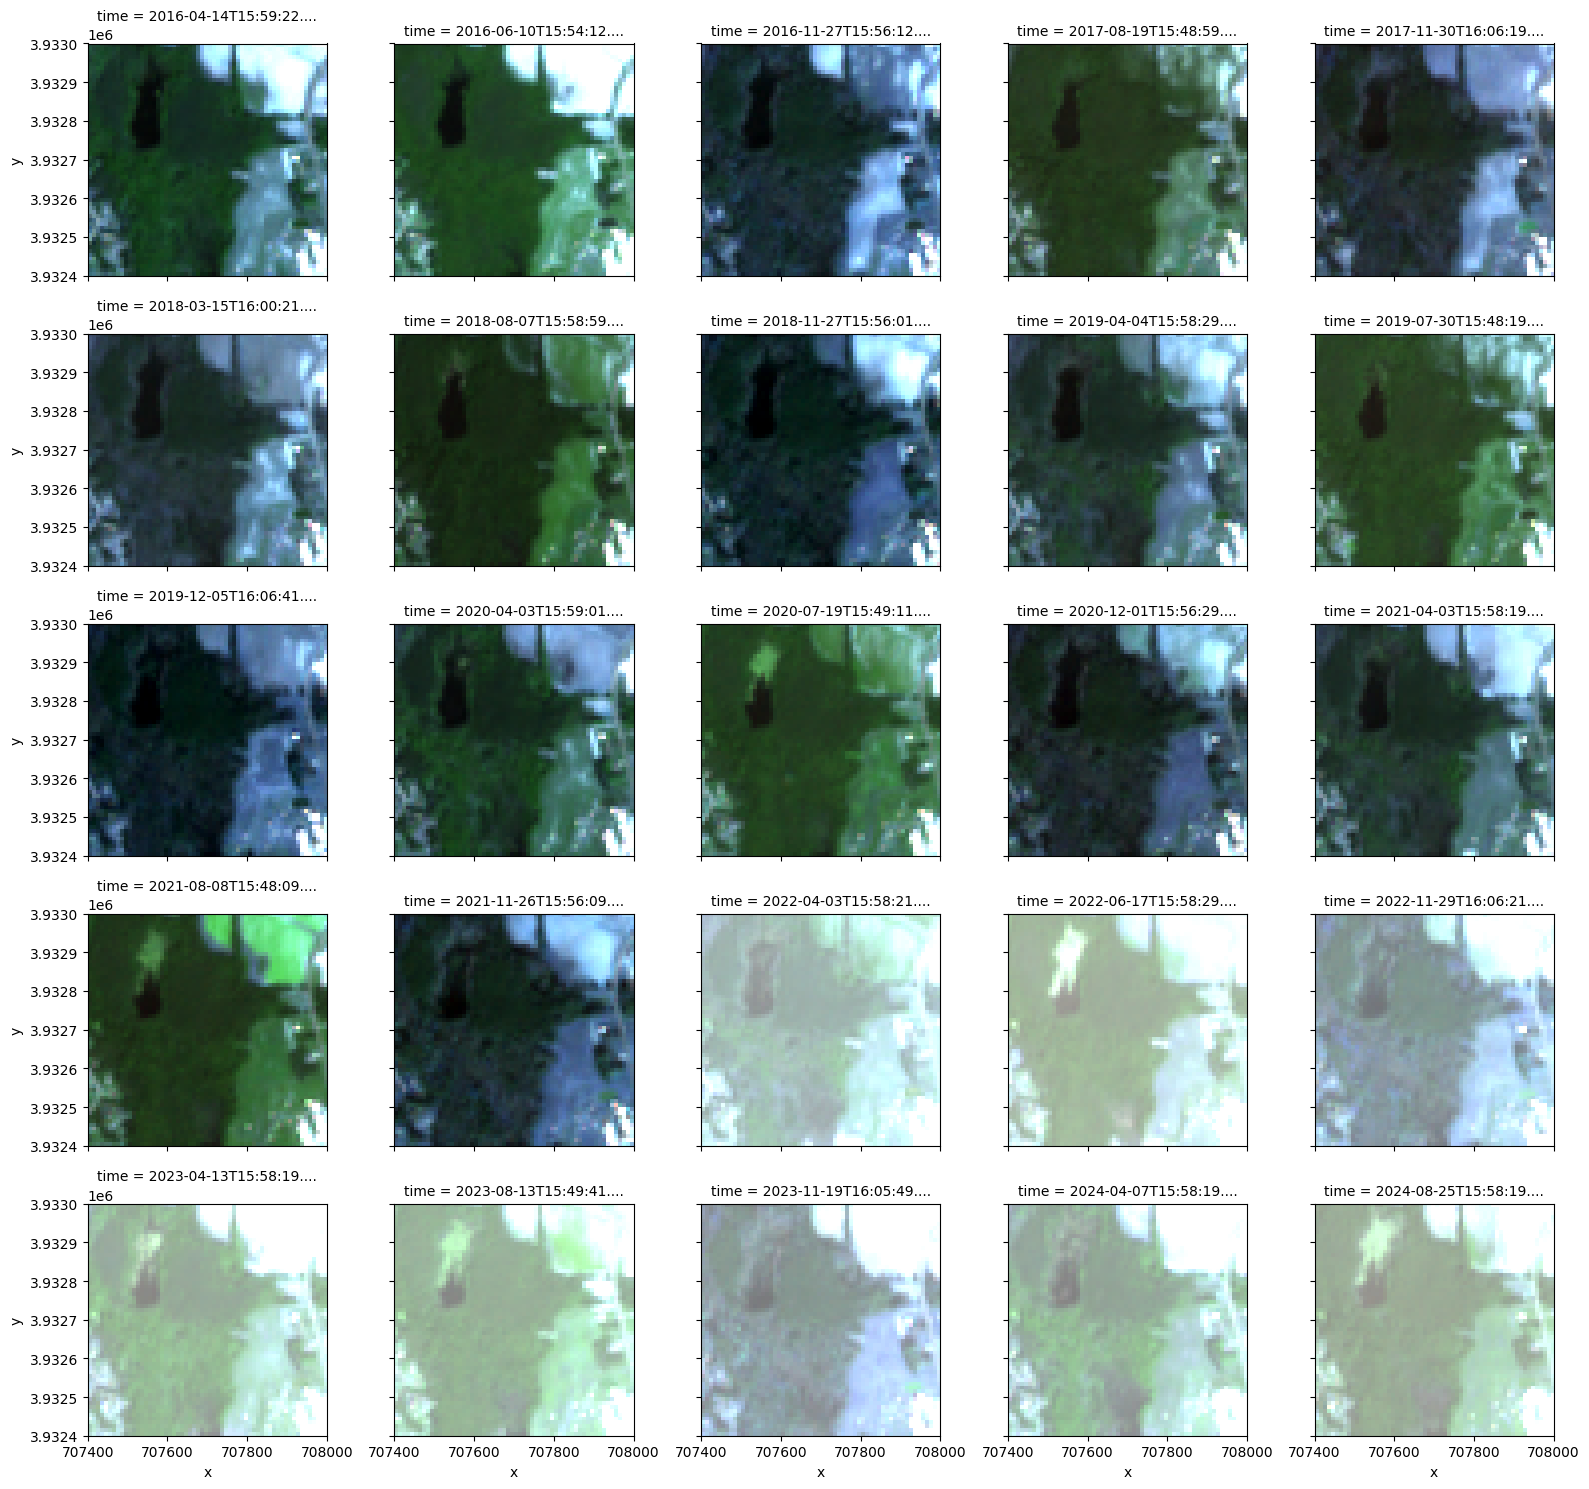

In [28]:

def get_by_idx(tile_idx, tiles_gdf, bands):
    tile_data_files = tiles_gdf.at[tile_idx, 'date_files_mapping']
    datasets = []
    for query_date in tile_data_files.keys():
        data_file = tile_data_files[query_date][0]
        ds = rioxarray.open_rasterio(data_file)
        date_str = ds.time
        date = np.datetime64(date_str, 'ns')
        ds = ds.assign_coords(band=bands)
        ds = ds.expand_dims({'time': [date]})
        datasets.append(ds)
    stacked_ds = xr.concat(datasets, dim='time')
    return stacked_ds

stack = get_by_idx(0, updated_tiles_gdf, bands)

stack.sel(band=["B02", "B03", "B04"]).plot.imshow(
    row="time", rgb="band", vmin=0, vmax=2000, col_wrap=5
)

In [ ]:
def get_mosaics_by_indices(indices, gdf, bands):

    # Collect all data files for the specified indices
    data_files = []
    for idx in indices:
        tile_data_files = gdf.at[idx, 'date_files_mapping']
        for query_date in tile_data_files.keys():
            data_file = tile_data_files[query_date][0]
            with rioxarray.open_rasterio(data_file) as ds:
                date_str = ds.time
            date = np.datetime64(date_str, 'ns')
            data_files.append({'idx': idx, 'data_file': data_file, 'date': date})

    # Get unique dates within the date range
    dates = sorted(set(f['date'] for f in data_files))

    mosaics = []

    for date in dates:
        # Collect data files for this date
        files_for_date = [f for f in data_files if f['date'] == date]

        # Open rasterio datasets for this date
        rasterio_datasets = []
        for f in files_for_date:
            src = rasterio.open(f['data_file'])
            rasterio_datasets.append(src)

        # Merge the datasets into a mosaic
        mosaic_array, out_trans = merge(rasterio_datasets)

        # Get metadata from one of the datasets
        out_meta = rasterio_datasets[0].meta.copy()
        out_meta.update({
            "height": mosaic_array.shape[1],
            "width": mosaic_array.shape[2],
            "transform": out_trans
        })

        # Generate coordinate arrays
        transform = out_trans
        height = out_meta['height']
        width = out_meta['width']
        res_x = transform.a  # Pixel width
        res_y = -transform.e  # Pixel height (negative due to coordinate system)

        x_coords = np.arange(width) * res_x + transform.c + res_x / 2
        y_coords = np.arange(height) * res_y + transform.f + res_y / 2

        # Create xarray DataArray from the mosaic
        mosaic_da = xr.DataArray(
            mosaic_array,
            dims=('band', 'y', 'x'),
            coords={
                'band': bands,
                'y': y_coords,
                'x': x_coords
            },
            attrs={
                'transform': transform,
                'crs': out_meta['crs']
            }
        )

        # Add time coordinate
        mosaic_da = mosaic_da.expand_dims({'time': [date]})

        mosaics.append(mosaic_da)

        # Close datasets to free resources
        for src in rasterio_datasets:
            src.close()

    # Stack the mosaics over time
    stacked_mosaics = xr.concat(mosaics, dim='time')

    return stacked_mosaics


# Define your parameters
indices = [0, 1, 2, 3]  # List of tile indices
bands = ['B02', 'B03', 'B04', 'B08']

# Call the function
stacked_mosaics = get_mosaics_by_indices(indices, updated_tiles_gdf, bands)

# Plot the mosaics (e.g., the RGB composite for the first time step)
if stacked_mosaics is not None:
    stacked_mosaics.sel(band=['B04', 'B03', 'B02']).plot.imshow(
        row='time', rgb='band', vmin=0, vmax=3000, col_wrap=5
    )


In [ ]:
# Paths to the urban data and satellite data directories
urban_data_folder = "../data/urban_gdb"
satellite_data_folder = "../data/tiles_gdb"

# Specific date for the satellite data
specific_date = "2016-01-02"

# Only load files for tile_0 in the urban dataset
urban_tile_files = glob.glob(os.path.join(urban_data_folder, "tile_0_*.tif"))

# List to hold the opened rasterio datasets for the urban data
urban_src_files_to_merge = []

for tif in urban_tile_files:
    src = rasterio.open(tif)
    urban_src_files_to_merge.append(src)

# Perform the merge for the urban mosaic
urban_mosaic, urban_out_trans = merge(urban_src_files_to_merge)

# Select bands B02 (Blue), B03 (Green), B04 (Red) for RGB
rgb_stack = get_mosaics_by_indices([0], tiles_gdf, ['B02', 'B03', 'B04', 'B08'],
                                   "2016-01-01", "2016-02-01")

# Select the bands B02 (Blue), B03 (Green), B04 (Red) for RGB
rgb_stack = rgb_stack.sel(band=["B02", "B03", "B04"])

rgb_array = rgb_stack.isel(time=0)  # Select the first (and only) time step

# Rearrange dimensions for plotting as RGB
rgb_array = rgb_array.transpose('y', 'x', 'band') / rgb_array.max()

# Plot the urban and satellite mosaics side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Plot the urban mosaic
rasterio.plot.show(urban_mosaic, transform=urban_out_trans, ax=ax1, cmap='viridis')
ax1.set_title("Urban Mosaic")

# Plot the satellite RGB mosaic
ax2.imshow(rgb_array)
ax2.set_title(f"Satellite Mosaic (RGB - {specific_date})")

plt.tight_layout()
plt.show()

In [ ]:
def merge_subdivided_tiles(input_tile_dir, output_merged_file):
    """
    Merge all subdivided tiles in the input directory into a single raster file.

    Parameters:
    - input_tile_dir (str): The directory containing the subdivided tiles (.tif files).
    - output_merged_file (str): The path to save the merged raster file.
    """
    # Collect all the .tif files in the input directory
    tile_files = glob.glob(os.path.join(input_tile_dir, "*.tif"))
    
    if not tile_files:
        print(f"No .tif files found in {input_tile_dir}")
        return
    
    # List to hold the opened rasterio datasets
    src_files_to_merge = []

    for tif in tile_files:
        src = rasterio.open(tif)
        src_files_to_merge.append(src)

    # Perform the merge
    mosaic, out_trans = merge(src_files_to_merge)

    # Get metadata from one of the source files
    out_meta = src_files_to_merge[0].meta.copy()

    # Update the metadata to reflect the new dimensions, transform, and CRS
    out_meta.update({
        "driver": "GTiff",
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": out_trans,
        "count": mosaic.shape[0],  # Update count to match the number of bands in the mosaic
        "dtype": mosaic.dtype  # Make sure the data type is set properly
    })

    # Write the merged raster to disk, ensuring all bands are written correctly
    with rasterio.open(output_merged_file, "w", **out_meta) as dest:
        for i in range(1, mosaic.shape[0] + 1):
            dest.write(mosaic[i - 1], i)

    # Close the opened files
    for src in src_files_to_merge:
        src.close()

    print(f"Merged raster saved to {output_merged_file}")

# Define your parameters
input_tile_dir = "../data/subdivided_urban_tiles_gdb"
output_merged_file = "../data/merged_urban_raster.tif"

if not os.path.exists(output_merged_file):
    # Call the function to merge the subdivided tiles
    merge_subdivided_tiles(input_tile_dir, output_merged_file)

In [ ]:
with rasterio.open(output_merged_file) as urban_resampled:
    rasterio.plot.show(urban_resampled, cmap='viridis')

In [ ]:
def get_stack_centroid_lat_lon(stack):
    # Extract the x and y coordinates
    x_coords = stack['x'].values
    y_coords = stack['y'].values
    # Compute the centroid in the dataset's CRS
    x_min = x_coords.min()
    x_max = x_coords.max()
    y_min = y_coords.min()
    y_max = y_coords.max()
    x_centroid = (x_min + x_max) / 2
    y_centroid = (y_min + y_max) / 2
    # Create a GeoDataFrame with the centroid point
    centroid_point = Point(x_centroid, y_centroid)
    gdf = gpd.GeoDataFrame(geometry=[centroid_point], crs=stack.rio.crs)
    # Reproject to WGS84 (EPSG:4326)
    gdf_wgs84 = gdf.to_crs('EPSG:4326')
    # Extract latitude and longitude
    lon = gdf_wgs84.geometry.x.values[0]
    lat = gdf_wgs84.geometry.y.values[0]
    return lat, lon

# Use the function on your stack
lat, lon = get_stack_centroid_lat_lon(stack)
print(f'Centroid Latitude: {lat}, Longitude: {lon}')

In [ ]:
# `git clone https://github.com/Clay-foundation/model.git`
# Download clay-v1-base.ckpt from https://huggingface.co/made-with-clay/Clay/tree/main

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
ckpt = "../clay-ckpt/clay-v1-base.ckpt"
metadata_path = "../model/configs/metadata.yaml" 
torch.set_default_device(device)

model = ClayMAEModule.load_from_checkpoint(
    ckpt, metadata_path=metadata_path, shuffle=False, mask_ratio=0
)

model.eval()
model = model.to(device)

In [31]:
# Extract mean, std, and wavelengths from metadata
platform = "sentinel-2-l2a"
metadata = Box(yaml.safe_load(open(metadata_path)))
mean = []
std = []
waves = []
# Use the band names to get the correct values in the correct order.
for band in stack.band.values:
    mean.append(metadata[platform].bands.mean[bands_map[str(band)]])
    std.append(metadata[platform].bands.std[bands_map[str(band)]])
    waves.append(metadata[platform].bands.wavelength[bands_map[str(band)]])

# Prepare the normalization transform function using the mean and std values.
transform = v2.Compose(
    [
        v2.Normalize(mean=mean, std=std),
    ]
)

In [33]:
# Prep datetimes embedding using a normalization function from the model code.
def normalize_timestamp(date):
    week = date.isocalendar().week * 2 * np.pi / 52
    hour = date.hour * 2 * np.pi / 24

    return (math.sin(week), math.cos(week)), (math.sin(hour), math.cos(hour))


datetimes = stack.time.values.astype("datetime64[s]").tolist()
times = [normalize_timestamp(dat) for dat in datetimes]
week_norm = [dat[0] for dat in times]
hour_norm = [dat[1] for dat in times]

# Prep lat/lon embedding using the
def normalize_latlon(lat, lon):
    lat = lat * np.pi / 180
    lon = lon * np.pi / 180

    return (math.sin(lat), math.cos(lat)), (math.sin(lon), math.cos(lon))

latlons = [normalize_latlon(lat, lon)] * len(times)
lat_norm = [dat[0] for dat in latlons]
lon_norm = [dat[1] for dat in latlons]

# Normalize pixels
pixels = torch.from_numpy(stack.data.astype(np.float32))
pixels = transform(pixels)

In [34]:
# Prepare additional information
datacube = {
    "platform": platform,
    "time": torch.tensor(
        np.hstack((week_norm, hour_norm)),
        dtype=torch.float32,
        device=device,
    ),
    "latlon": torch.tensor(
        np.hstack((lat_norm, lon_norm)), 
        dtype=torch.float32, device=device
    ),
    "pixels": pixels.to(device),
    "gsd": torch.tensor(0.6, device=device),
    "waves": torch.tensor(waves, device=device),
}

In [ ]:
with torch.no_grad():
    unmsk_patch, unmsk_idx, msk_idx, msk_matrix = model.model.encoder(datacube)

# The first embedding is the class token, which is the
# overall single embedding. We extract that for PCA below.
embeddings = unmsk_patch[:, 0, :].cpu().numpy()

In [ ]:
# Run PCA
pca = decomposition.PCA(n_components=1)
pca_result = pca.fit_transform(embeddings)

plt.xticks(rotation=-45)

plt.scatter(stack.time, pca_result, color="green")
